## Assignment: Optimization methods

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

## Task

Implement different optimization methods wihout using `autograd` or `torch.optim`. You are only allowed to use pytorch as yur numeric computation framework. The only exception is `visualize` function

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

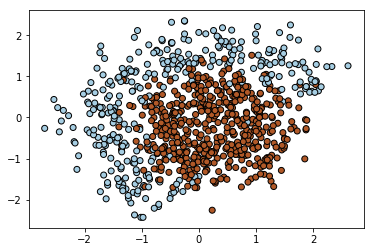

In [64]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()


X, y = torch.FloatTensor(X), torch.FloatTensor(y)
# X = expand(X)

In [65]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [66]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    expX = expand(X)
    w = w.reshape(6, 1)
    tmp = torch.mm(expX, w)
    return tmp.sign()

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [108]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    # Your code here
    tmp = 1 - y*w.reshape(1, 6).mm(expand(X).t())
    return torch.where(tmp > 0, tmp, torch.Tensor([0])).sum()/X.shape[0]


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    N = X.shape[0]
    y_pr = compute_loss(X, y, w)
    rs = -y.reshape(N, 1) * expand(X)
    res = torch.where((y * w.reshape(1, 6).mm(expand(X).t())).reshape(N, 1) < 1, 
    rs, torch.zeros_like(rs))

#     div = classify(X, w) - y.reshape(X.shape[0], 1)
#     X = expand(X)
    
    return res.sum(dim = 0)/N#div.reshape(1, X.shape[0]).mm(X).reshape(-1)
    # Your code here
#     return -y.reshape(1, X.shape[0]).mm(expand(X)).sum()

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

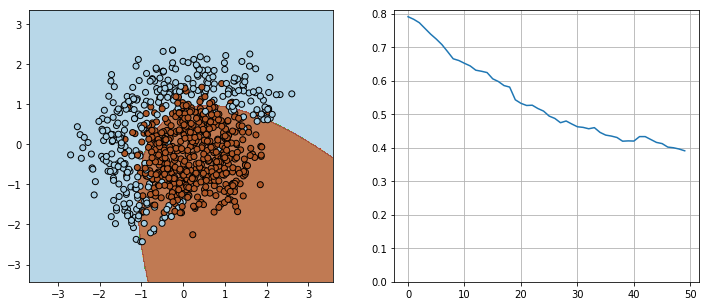

<Figure size 864x360 with 0 Axes>

In [109]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

# random.seed(5)
alpha = 0.04

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

print(w.shape)
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

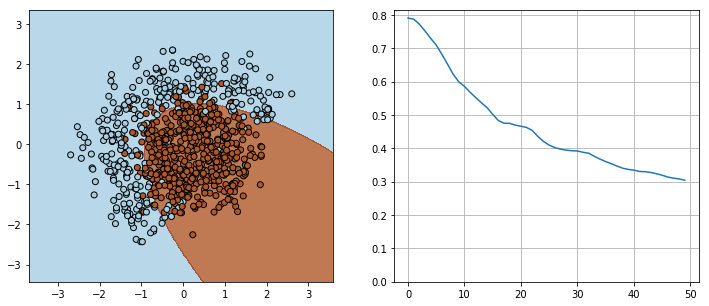

<Figure size 864x360 with 0 Axes>

In [104]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.03 # learning rate
mu    = 0.7 # momentum

v = torch.zeros_like(w)

# random.seed(5)
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w) # Your code here
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

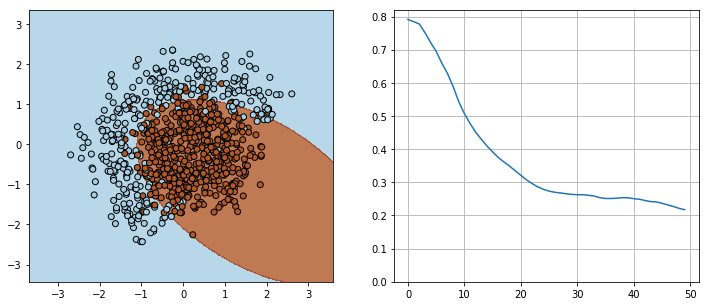

<Figure size 864x360 with 0 Axes>

In [105]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.03# learning rate
mu    = 0.9# momentum

v = torch.zeros_like(w)

# random.seed(5)
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
#     v = mu * v
    w_ = w + mu * v
    grad = compute_grad(X[ind,:], y[ind], w_)
    v = mu * v - alpha * grad
#     v = mu * (mu * v - alpha * grad) - alpha * grad
    w = w + v # Your code here

visualize(X, y, w, loss, n_iter)
plt.clf()

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

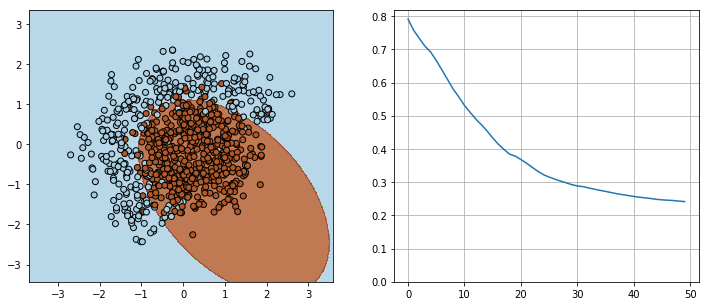

<Figure size 864x360 with 0 Axes>

In [107]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.01# learning rate
beta = 0.9# (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu = 0.999# (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 0.00000001# A small constant for numerical stability

v = torch.zeros_like(w)
g = torch.zeros_like(w)


n_iter = 50
batch_size = 4
# random.seed(5)
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    dw = compute_grad(X[ind,:], y[ind], w)
    v = beta * v + (1 - beta) * dw
    g = mu * g + (1 - mu) * (dw**2)
    
    w = w - alpha * v / (torch.sqrt(g) + eps)# Your code here

visualize(X, y, w, loss, n_iter)
plt.clf()